In [1]:
# Importando bibliotecas

from os import mkdir, path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import datetime
import seaborn as sns


In [416]:
# Funções úteis

def dt_to_unix_ns(date):
    return datetime.datetime.timestamp(date) * 1000 * 1000

def unix_ns_to_dt(x):
    return pd.to_datetime(x, unit='us', origin='unix')

def kb_to_mb(x):
    return x / 1000

def truncate_microseconds(date):
    return date.replace(microsecond=0)

def extract_metric(api_url, metric, filename):
    response = requests.get(f'{api_url}/api/metrics?metric={metric}')

    with open(filename, mode='wb') as f:
        f.write(response.content)

def extract_node(api_url):
    response = requests.get(f'{api_url}/api/health')

    data = response.json()

    return data.get('node', 'no-node')

def extract_data(path, nodes, api_urls):
    for api_url in api_urls:
        node = extract_node(api_url)

        nodes.append(node)

        for metric in metrics:
            extract_metric(api_url=api_url, metric=metric, filename=f'{path}/{node}-{metric}.csv')


def mkdir_if_not_exists(dir_path):
    if (not path.exists(dir_path)):
        mkdir(dir_path)

def read_metrics_data(path, filename, start_time, end_time):
    data = pd.read_csv(f'{path}/{filename}')

    data.columns = ['node', 'metric_name', 'label', 'measurement', 'time']

    # data = data[(data['time'] >= start_time) & (data['time'] <= end_time)]

    data['datetime'] = data['time'].apply(unix_ns_to_dt)
    # data['datetime'] = data['datetime'].apply(truncate_microseconds)

    data = data.set_index('datetime')

    data = data.sort_index()

    return data

In [407]:
# Definindo variáveis

scenarios = {
    'cenario-1': {
        # Started at: 05/19/2022 19:28:07
        # Ended at: 05/19/2022 19:29:57
        'start_date': datetime.datetime(2022, 5, 19, 19, 25),
        'end_date': datetime.datetime(2022, 5, 19, 19, 40)
    },
    'cenario-2': {
        # Started at: 05/19/2022 20:10:35
        # Ended at: 05/19/2022 20:12:25
        'start_date': datetime.datetime(2022, 5, 19, 20, 10),
        'end_date': datetime.datetime(2022, 5, 19, 20, 20)
    },
    'cenario-3': {
        # Started at: 05/19/2022 20:54:10
        # Ended at: 05/19/2022 20:56:00
        'start_date': datetime.datetime(2022, 5, 19, 20, 50),
        'end_date': datetime.datetime(2022, 5, 19, 21, 10)
    },
    'cenario-4': {
        # Started at: 05/20/2022 21:18:15
        # Ended at: 05/20/2022 21:20:08
        'start_date': datetime.datetime(2022, 5, 20, 21, 18),
        'end_date': datetime.datetime(2022, 5, 20, 21, 21),
        'plot_total_events_processed': True,
        'expected_events_processed': 20_000,
        'expected_messages_processed': 10_000
    }
}

scenario = 'cenario-4'

start_date = scenarios[scenario].get('start_date')
end_date = scenarios[scenario].get('end_date')

start_date_in_unix_ns = dt_to_unix_ns(start_date)
end_date_in_unix_ns = dt_to_unix_ns(end_date)

plot_total_events_processed = scenarios[scenario].get(
    'plot_total_events_processed',
    False
)

metrics = [
    'vm.memory.total',
    'vm.system_counts.process_count',
    'vm.system_counts.atom_count',
    'vm.system_counts.port_count',
    'events.total',
    'events.process_time',
    'mqtt.total',
    'mqtt.process_time'
]

api_urls = ['http://localhost:4001',
            'http://localhost:4002',
            'http://localhost:4003']


data_path = f'data/{scenario}'

mkdir_if_not_exists(data_path)

output_path = f'output/{scenario}'

mkdir_if_not_exists(output_path)

nodes = ['fogex@node-1', 'fogex@node-2', 'fogex@node-3']

nodes


['fogex@node-1', 'fogex@node-2', 'fogex@node-3']

In [137]:
# Extraiondo dados
scenario = 'cenario-4'
data_path = f'data/{scenario}'
nodes = []

extract_data(data_path, nodes, api_urls)

nodes

['fogex@node-1', 'fogex@node-2', 'fogex@node-3']

In [368]:
# Sandbox
scenario = 'cenario-4'

node = nodes[0]

start_date = scenarios[scenario].get('start_date')
end_data = scenarios[scenario].get('end_date')

start_date_in_unix_ns = dt_to_unix_ns(start_date)
end_date_in_unix_ns = dt_to_unix_ns(end_data)

data_path = f'data/{scenario}'

metric = 'vm.memory.total'

data = read_metrics_data(
    data_path, f'{node}-{metric}.csv', start_date_in_unix_ns, end_date_in_unix_ns)

data['time'] = data['time'].apply(unix_ns_to_dt)
# data['measurement'] = data['measurement'].apply(kb_to_mb)

data = data.set_index('time')

data.count()


node           45
metric_name    45
label           0
measurement    45
dtype: int64

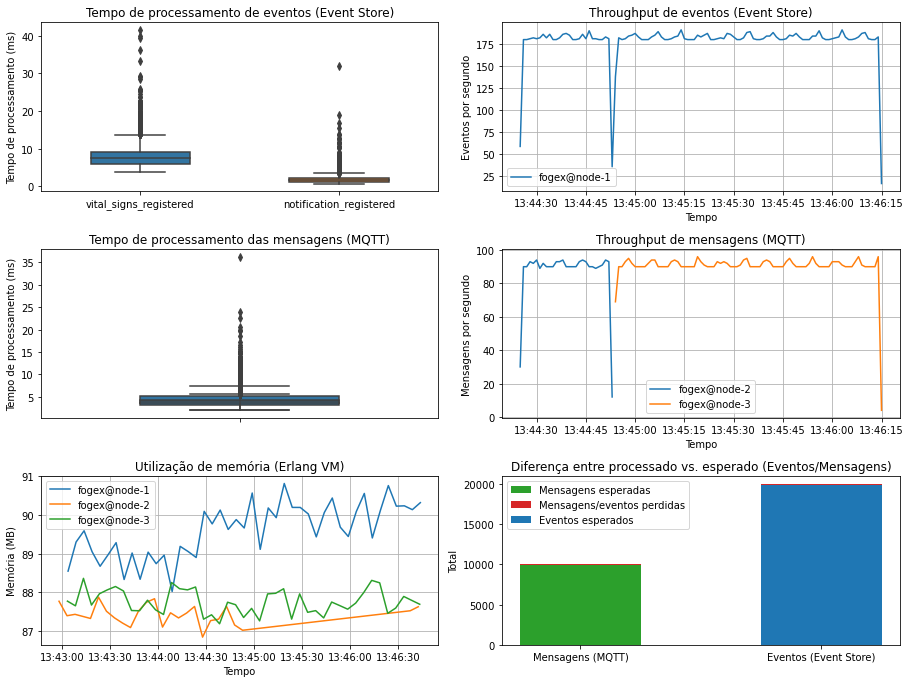

In [418]:
# Plotando a métrica events.process_time
datas = []
metric = 'events.process_time'

for node in nodes:
    try:
        data = read_metrics_data(
            data_path, f'{node}-{metric}.csv', start_date_in_unix_ns, end_date_in_unix_ns)

        datas.append((node, data))
    except:
        continue

default_figsize = (6.4, 4.8)
multiplier = (2, 2)

figsize = tuple(ele1 * ele2 for ele1, ele2 in zip(default_figsize, multiplier))

fig = plt.figure(figsize=figsize)

plt.subplot(3, 2, 1)
plt.title("Tempo de processamento de eventos (Event Store)")

for (node, data) in datas:
    g = sns.boxplot(x=data['label'], y=data['measurement'], data=data, width=0.5)

    g.set_ylabel('Tempo de processamento (ms)')
    g.set_xlabel('')

# Plotando a métrica events.total
datas = []
metric = 'events.total'

for node in nodes:
    try:
        data = read_metrics_data(
            data_path, f'{node}-{metric}.csv', start_date_in_unix_ns, end_date_in_unix_ns)

        data['datetime in seconds'] = data['time'].apply(unix_ns_to_dt)
        data['datetime in seconds'] = data['datetime in seconds'].apply(
            truncate_microseconds)

        groups = data.groupby('datetime in seconds')

        new_data = groups.aggregate(len)

        datas.append((node, new_data))
    except:
        continue

plt.subplot(3, 2, 2)

plt.title("Throughput de eventos (Event Store)")

for (node, data) in datas:
    plt.plot(data['measurement'], label=node)

    plt.ylabel('Eventos por segundo')
    plt.xlabel('Tempo')

plt.legend()
plt.grid()

# Plotando a métrica mqtt.process_time
datas = []
metric = 'mqtt.process_time'

for node in nodes:
    try:
        data = read_metrics_data(
            data_path, f'{node}-{metric}.csv', start_date_in_unix_ns, end_date_in_unix_ns)

        datas.append((node, data))
    except:
        continue

plt.subplot(3, 2, 3)
plt.title("Tempo de processamento das mensagens (MQTT)")

for (node, data) in datas:
    g = sns.boxplot(y=data['measurement'], data=data, width=0.5)

    g.set_ylabel('Tempo de processamento (ms)')
    g.set_xlabel('')

# Plotando a métrica mqtt.total
datas = []
metric = 'mqtt.total'

for node in nodes:
    try:
        data = read_metrics_data(
            data_path, f'{node}-{metric}.csv', start_date_in_unix_ns, end_date_in_unix_ns)

        data['datetime in seconds'] = data['time'].apply(unix_ns_to_dt)
        data['datetime in seconds'] = data['datetime in seconds'].apply(
            truncate_microseconds)

        groups = data.groupby('datetime in seconds')

        new_data = groups.aggregate(len)

        datas.append((node, new_data))
    except:
        continue

plt.subplot(3, 2, 4)
plt.title("Throughput de mensagens (MQTT)")

for (node, data) in datas:
    plt.plot(data['measurement'], label=node)

    plt.ylabel('Mensagens por segundo')
    plt.xlabel('Tempo')

plt.legend()
plt.grid()

# Plotando a métrica vm.memory.total
datas = []
metric = 'vm.memory.total'

for node in nodes:
    data = read_metrics_data(
        data_path, f'{node}-{metric}.csv', start_date_in_unix_ns, end_date_in_unix_ns)

    data['measurement'] = data['measurement'].apply(kb_to_mb)

    datas.append((node, data))

plt.subplot(3, 2, 5)
plt.title("Utilização de memória (Erlang VM)")

for (node, data) in datas:
    plt.plot(data['measurement'], label=node)

    plt.ylabel('Memória (MB)')
    plt.xlabel('Tempo')

plt.legend()
plt.grid()

# Plotando as métricas de events.total vs. esperado e mqtt.total vs. esperado
if (plot_total_events_processed):
    metric = 'events.total'
    expected_events_processed = scenarios[scenario].get(
        'expected_events_processed'
    )

    events_processed = 0

    messages_processed = 0
    expected_messages_processed = scenarios[scenario].get(
        'expected_messages_processed'
    )

    for node in nodes:
        try:
            data = read_metrics_data(
                data_path, f'{node}-{metric}.csv', start_date_in_unix_ns, end_date_in_unix_ns)
        except:
            continue

        events_processed += data['measurement'].sum()

    metric = 'mqtt.total'

    for node in nodes:
        try:
            data = read_metrics_data(
                data_path, f'{node}-{metric}.csv', start_date_in_unix_ns, end_date_in_unix_ns)
        except:
            continue

        messages_processed += data['measurement'].sum()

    plt.subplot(3, 2, 6)

    plt.title('Diferença entre processado vs. esperado (Eventos/Mensagens)')

    width = 0.5
    missing_events = expected_events_processed - events_processed
    missing_messages = expected_messages_processed - messages_processed

    plt.bar('Mensagens (MQTT)', messages_processed, width, color='tab:green', label='Mensagens esperadas')
    plt.bar('Mensagens (MQTT)', missing_messages, width, bottom=messages_processed, color='tab:red', label='Mensagens/eventos perdidas')

    plt.bar('Eventos (Event Store)', events_processed, width, color='tab:blue', label='Eventos esperados')
    plt.bar('Eventos (Event Store)', missing_events, width, bottom=events_processed, color='tab:red')

    plt.ylabel('Total')

    plt.legend()

# Mostrar e salvar o gráfico

plt.tight_layout()
plt.savefig(f'{output_path}/{scenario}.png')
plt.show()


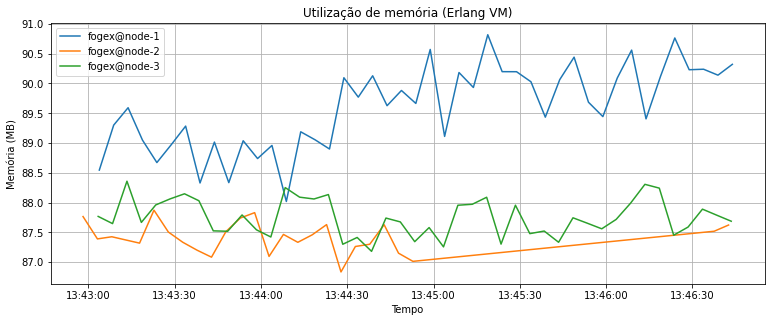

In [417]:
# Plotando a métrica vm.memory.total
datas = []
metric = 'vm.memory.total'


for node in nodes:
    data = read_metrics_data(data_path, f'{node}-{metric}.csv', start_date_in_unix_ns, end_date_in_unix_ns)

    data['measurement'] = data['measurement'].apply(kb_to_mb)

    datas.append((node, data))

ffig = plt.figure(figsize=(12.8, 4.8))

plt.ylabel('Memória (MB)')
plt.xlabel('Tempo')

for (node, data) in datas:
    plt.plot(data['measurement'], label=node)

plt.legend()
plt.grid()

plt.title("Utilização de memória (Erlang VM)")

plt.savefig(f'{output_path}/{metric}.png')

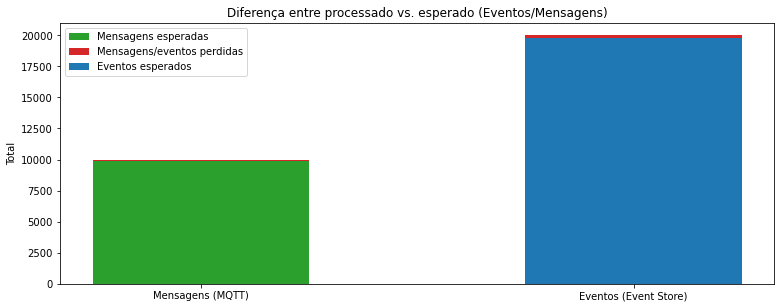

In [419]:
metric = 'events.total'
expected_events_processed = scenarios[scenario].get(
    'expected_events_processed'
)

events_processed = 0

messages_processed = 0
expected_messages_processed = scenarios[scenario].get(
    'expected_messages_processed'
)

for node in nodes:
    try:
        data = read_metrics_data(
            data_path, f'{node}-{metric}.csv', start_date_in_unix_ns, end_date_in_unix_ns)
    except:
        continue

    events_processed += data['measurement'].sum()

metric = 'mqtt.total'



for node in nodes:
    try:
        data = read_metrics_data(
            data_path, f'{node}-{metric}.csv', start_date_in_unix_ns, end_date_in_unix_ns)
    except:
        continue

    messages_processed += data['measurement'].sum()

fig = plt.figure(figsize=(12.8, 4.8))

plt.title('Diferença entre processado vs. esperado (Eventos/Mensagens)')

width = 0.5
missing_events = expected_events_processed - events_processed
missing_messages = expected_messages_processed - messages_processed

plt.bar('Mensagens (MQTT)', messages_processed, width, color='tab:green', label='Mensagens esperadas')
plt.bar('Mensagens (MQTT)', missing_messages, width, bottom=messages_processed, color='tab:red', label='Mensagens/eventos perdidas')

plt.bar('Eventos (Event Store)', events_processed, width, color='tab:blue', label='Eventos esperados')
plt.bar('Eventos (Event Store)', missing_events, width, bottom=events_processed, color='tab:red')

plt.ylabel('Total')

plt.legend()
